# Principle of data reduction and normalization on BIFROST

## Introduction
This short document describes the overall data reduction steps in rough detail. The purpose of this document is to explain the operations used on the raw data, accessible to any user or collaborator, without getting into any unnecessary detail. This is intended as a living document, but the end goal is a having the document in a state to be presentable to users. 

## Data reduction flow
The proposed flow (version 1) of the data from the EFU to the S($Q$, $\omega$) data file is show in the diagram below.

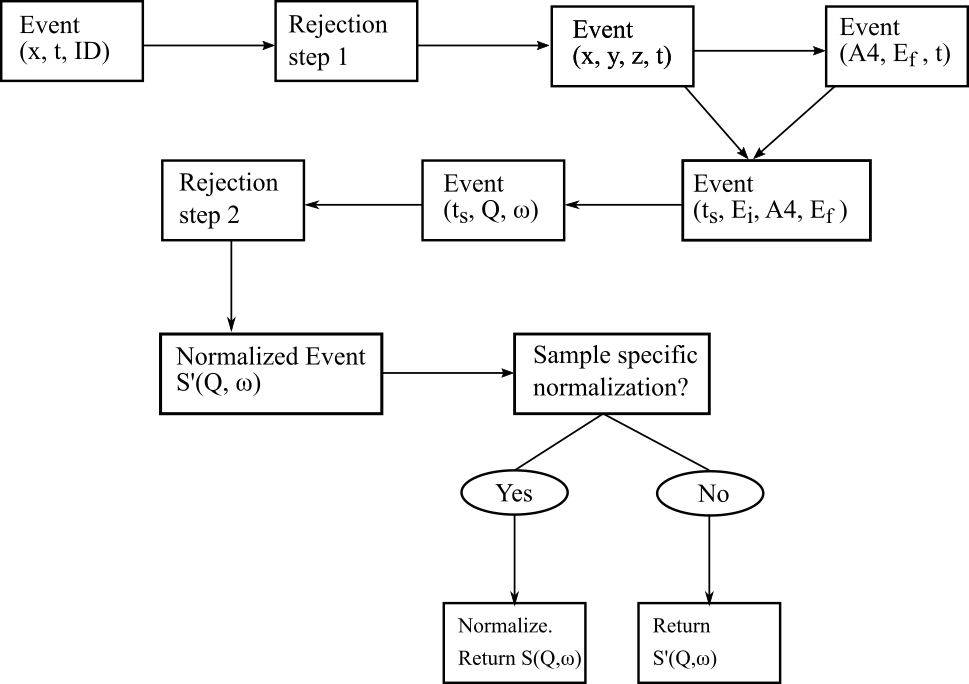

The steps necessary will be roughly explained in the sections below. Below is the more general way to approach this, there may well be simplifications and makes reduction faster and simpler, with no discernable impact on interpretation. A second version of this document should/could be simpler.

### Raw event
The raw event comes from the event formation unit (EFU) in the form of a position along the tube $x$, a detection time $t$ and a tube $ID$ number. The position of each tube is known, and therefore we in principle have 3 position coordinates and a time, from which we can calculate the scattering angle of the neutron, the take-off angle off the analyser, and the flight path. Before calculating anything a first look at usefulness might be good. 

### First rejection step
An option would be to reject some data before reducing it. The EFU already does this to an extent, by masking out the sensitive line on the detectors. Here, we could have a more flexible criterion, if we have a bad section of detector tube, if we are on the tail of the pulse, etc. The only reason to do this would be to avoid misinterpreting a count as a credible measurement. Whether to even do this seems highly debatable, but i want to flag the option. 

### Physical space-time coordinates (x, y, z, t)
The right-handed coordinate system for data reduction should have origo at the sample position, $z$ vertical, and the $x$ axis connecting the origo to the center-of-mass of the middle blade of the analyser in queston. 
Each detector axis has a nominal position relative to the sample point. A detector tube can be represented as a line segment extending along $x$ with the axis positioned at $(y, z)$. The latter two coordinates are given by design, designated $(y_d, z_d)$, and designating the measurement of $x$ as $x_m$, the simplest return is:

Simple coordinates:
$(x, y, z, t) = (x_m, y_d, z_d, t) = (\vec{P}_d, t)$.   

A more complicated return would take into account *calibrated* detector positions. The detectors sit inside modules, holding **three triplets each**. These modules are mounted on flanges, flat and **with a surface normal parallel to z**. General 3D rotation around arbitrary axes are not so trivial, but my suggestion is to keep this as simple as possible as rotations are small. The only likely shift of the detectors would come via a rotation of the module as a whole around the central module axis followed by an arbitrary translation of the module as a whole. There might be more complicated shifts, but we are unlikely to be able to calibrate more than two transformations. So, the complicated return would be:

Complicated position coordinates:
$(x, y, z) = \vec{P}_o = \mathbf{R}(\vec{z}, \theta)(\vec{P}_d - \vec{T}_{mod}) + \vec{T}_{mod} + \mathbf{R}(\vec{z}, \theta_{trip})\vec{T}_{off}$, 

where $\mathbf{R}(\vec{z}, \theta)$ is an Euler rotation matrix of $\theta$ degrees around $z$, $\vec{T}_{mod}$ is the translation vector between the module center and the triplet center in the $(x, y)$-plane, $\vec{T}_{off}$ is the translation offset of the module as a whole in the $(x, y)$ plane, where $\theta_{trip})\vec{T}_{off}$ is expressed in local triplet coordinates $\theta_{trip)$ is the rotation angle between adjacent triplets. This requires us to calibrate three parameters for a 3-triplet module, $\theta$, $x_{off}$ and $y_{off}$.  (Note to Greg: I'm sure there is a mistake somwhere here, but will go throught it more formally if we agree on the approach.)

For the vanadium scan calibration, we need to normalize for the efficiency of the (filter/analyser/detector)-setup, which occurs via a lookup-table for calibration constants for all $x$, denoted

$I_n = E(ID, x_m)$

And so the information to give to the next step is:

$(x, y, z, t, I_n)$


### Laboratory frame coordinate system event
Initially, the measured (calibrated) detection distance from the $(y,z)$ scattering plane of the analyzer channel

$dA4 = \mathrm{atan} \left(\frac{y}{L_{sa} + L_{ad}} \right)$

Please note that dA4 has a sign. The *mean* point of scattering off the analyser is naively calculated as $\vec{P}_a  =  (L_{sa}, \; \mathrm{tan}(dA4)\cdot L_{sa}, \; 0 )$ 

The scattered neutron has propagation unit vector:

$\vec{k}_{ad}  = \frac{P_o - P_a}{||P_o - P_a||}$ 

The unit propagation vector of the neutron incident on the sample is:

$\vec{k}_{sa}  = (\mathrm{cos}(dA4), \mathrm{sin}(dA4), 0)$ 

The scattering angle is determined by

$\mathrm{cos}(A6) = \vec{k}_{sa} \cdot \vec{k}_{ad}$

The directly calculated scattering angle, valid for all tubes and positions, allows us to use Braggs law - using (002) of HOPG - to get wavelength, velocity and energy of the detected neutron:

   $\lambda_f = 2 \cdot 3.355 \cdot \mathrm{sin}(A6/2)$  Å
   
   $v_f = \frac{3956}{\lambda_f}  \frac{m}{s}$
   
   $E_f = \left( \frac{9.045}{\lambda_f}\right )^2$  meV
   
The scattering angle is the nominal scattering angle for the analyser in question $AX$ plus the incremental angle detected by the PSD:

$A4 = AX + dA4$

Information for next step is:

$(x, y, z, t, I_n, \lambda_f, v_f, E_f, A4)$

   
                    
### Flightpath and calculating $E_i$
To get $E_i$ we need the flightpath from sample to detector. Since we already have the scattering and detection point, an overcomplicated way of getting the flightpath is:

$\Delta L_{sd} = ||P_a|| + ||P_o - P_a||$

Presumably, since the travel distance from any analyser point to two adjacent tubes are almost identical, it is simpler to use:

$\Delta L_{sd} = \frac{L_{sa} + L_{ad}}{\textrm{cos}(dA4)}$ 

Next, the scattering time of the neutron at the sample position is calculated:

$\mathrm{t}_s = t - \frac{\Delta L_{sd}}{v_f}$

In the case of PSC spinning, the incident velocity is then:

$v_i = \frac{162-z_{psc}}{\mathrm{t}_s - \mathrm{T}_{PSC}}$ 

where $z_{PSC}$ is the PSC distance from moderator, and $\mathrm{T}_{PSC}$ is the center of the relevent PSC pulse in time. In case of PSC parked, the incident velocity is:

$v_i = \frac{162}{\mathrm{t}_s - (\mathrm{T}_0+t_{rise}+\tau/2)}$ 

where $\tau$ is the ESS pulse width, $t_{rise}$ is the rise time of the pulse and $T_0$ is the start time of the proton pulse. The relevant ESS/PSC pulse is determined via software / EFU. The pulse is in principle also recorded by the fission monitor after the PSC. There might be a flag telling us that there was no pulse. This is all to be worked out in detail later on. Now $E_i$ can be calculated:

$\lambda_i = \frac{3956}{v_i}$  Å
   
$E_i = \left( \frac{9.045}{\lambda_i}\right )^2$  meV

Information to forward
$(k_i, k_f, A4, I, t_s)$

(Greg: From a computational point of view, it might make sense to just keep variables already computed. )

### Calculating $Q$ and $\omega$
Energy transfer here means to the sample, to $\Delta E$ is positive when the neutron looses energy. So:

$\Delta E = E_i - E_f$

Momentum transfer $Q$ is a vector in the horizontal plane of a coordinate system were $x$ is along the primary beam path axis and coordinate system is righthanded. 

The wavevector transfer is given in this laboratory coordinate system by:
$\vec{Q} = \begin{pmatrix}
k_i - \mathrm{cos}(A4) k_f\\
- \mathrm{sin}(A4)k_f 
\end{pmatrix}$

The length of $Q$ is given by

$|Q| = \sqrt{|k_i|^2 + |k_f|^2 -2|k_i||k_f|\textrm{cos}(A4)}$

If we assume a high symmetry sample crystal lattice, where $\alpha = \beta = \gamma = 90^{\circ}$, the wavevector transfer in the **sample** coordinate system is given by the sample rotation, where the $H$-axis of the system is along $x$ and the $K$ along $y$. $H$ and $K$ are here arbitrarily chosen.
$\vec{Q}_s = \begin{pmatrix}
Q_H\\
Q_K 
\end{pmatrix} = \begin{bmatrix}\cos \omega &-\sin \omega \\\sin \omega &\cos \omega \end{bmatrix} \begin{pmatrix} k_i - \mathrm{cos}(A4) k_f\\
- \mathrm{sin}(A4)k_f \end{pmatrix}$

For monoclinic symmetry, or lower, it gets more complicated - which is dealt with in more detail in the designated document (Greg, surely there are standard code for this in python etc). Next step is normalizing $Q_H$ and $Q_K$ to the reciprocal lattice units, and so on. 

### Second rejection step
Once again we can reject data. Of course, simple masking should be done by the user, or via a designated software where masks can be changed. But we can also make the decision for the user. Bragg peak intensities are not credible, for instance. Again, this is a debate about what to leave up to the user. If we know that some chunk of S(Q, $\omega$) is useless, there is an argument to be made to ditch that data in data reduction, rather than let users fit garbage. But of course very dangerous.

### Instrumental normalization
Generally, the magnetic differential scattering cross section is:

$\left( \frac{d^2 \sigma}{d\Omega dE_f}\right)_{mag}  =  \frac{(\gamma R_0)^2}{2 \pi \hbar} \frac{k_f}{k_i} N_m |\frac{1}{2}gF(Q)|^2 e^{-W_d}  \sum_{\alpha \beta} \left( \delta_{\alpha \beta} - \hat{Q_{\alpha}}\hat{Q_{\beta}}\right) \sum_{l}e^{i Q \cdot {\bf{l}}} \sum_{d' d} e^{i Q \cdot ({\bf{d}}-{\bf{d'}})}\nonumber \\
								      \times   \int_{- \infty}^{\infty} \langle S^{\alpha}_{0d'}(0)S^{\beta}_{ld}(t)\rangle e^{-i \omega t} dt$

where $N_m$ is the number of magnetic units cells, $Q$ is the momentum transfer, $\alpha$ and $\beta$ are cartesian spin coordinates, $l$ and $d$ are lattice and basis coordinates of the magnetic ion(s), and so on (usual meanings). Most definitions of $S(Q, \omega)$ does not include the form factor, but as anything sample dependent is left for the user to deal with, we define $S(Q, \omega)$ somewhat differently

$I = C_p \cdot N_f(\lambda_i) \cdot N_b(ID, x) \cdot \frac{k_f}{k_i} \cdot S(Q, \omega)$

where,

$S(Q, \omega) = \frac{(\gamma R_0)^2}{2 \pi \hbar}N_m |\frac{1}{2}gF(Q)|^2 e^{-W_d}  \sum_{\alpha \beta} \left( \delta_{\alpha \beta} - \hat{Q_{\alpha}}\hat{Q_{\beta}}\right) \sum_{l}e^{i Q \cdot {\bf{l}}} \sum_{d' d} e^{i Q \cdot ({\bf{d}}-{\bf{d'}})}\nonumber \\
								      \times   \int_{- \infty}^{\infty} \langle S^{\alpha}_{0d'}(0)S^{\beta}_{ld}(t)\rangle e^{-i \omega t} dt$

and where $C_p$ is an unkown scaling factor (absorbtion in sample + SE etc), $N_f(\lambda_i)$ is the normalization for the incoming flux and $N_b$ is the normalization factor for backend. For flux normalization, we need information from the normalization monitor, which can turn out to be non-trivial. For the purposes of this document, we assume that we have a set of binned count rates, with 20 us resolution. From the previous calculations we know the incident velocity of the neutron in question, so the time at which to get the monitor count is:

$T_{m} = \mathrm{t_s} - \frac{\Delta x_{ms}}{v_i}$

The flux normalization factor is

$N_{f} = C_m \cdot I_m(T_{m}) \cdot k_i$,

where $C_m$ is a constant (could be conveniently arbitrary), $I_m$ is the monitor count rate and $k_i$ is the incident wavevector, as absorbtion is inversely proportional with $k_i$. The normalization due to graphite reflectivities

The observed intensity $I(Q, \omega)$ can be expressed in terms of experimental parameters and the physics of the sample 

$I(Q, \omega)  = C_p \cdot N_f(\lambda_i) \cdot N_b(ID, x) \cdot \frac{k_f}{k_i} \cdot S(Q, \omega) \\
               = C_p \cdot C_m \cdot I_m(T_{m}) \cdot N_b(ID, x) \cdot k_f \cdot S(Q, \omega)$

Where, $I(Q,\omega)$ is just the backend-normalized count noted $I$ and $S(Q, \omega)$ is the sample scattering function.  A scaled scattering function would then be

$S(Q, \omega) = \frac{I(Q, \omega)}{ C_p \cdot C_m \cdot I_m(T_{m}) \cdot N_b(ID, x) \cdot k_f}$

Hopefully, due to the inclusion of $k_f$ this allows us to compare count rate for different analyser sets. There ios a discussion about units here, that is left for later.

Greg: I know the resolution volume scales with $k_f$ cubed, but we are not integrating here. So i am a bit in doubt about how to actually compare data from different analyzer banks. I wonder if anyone has actually tested two datasets against eachother measured with different $k_f$ on a TAS.  



### Sample specific normalization





